**NOTE**:  This notebook was adapted from the notebook offered for download on Sci-kit learn website at https://scikit-learn.org/stable/auto_examples/svm/plot_iris.html.

I have broken up the notebook into more cells and added my own cells intermittently, plus made some additions to the plot relevant to my specific demo.

In [1]:
import numpy as np
import pandas as pd
from sklearn import svm, datasets
from sklearn.externals import joblib

import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_rows', 200)

(This block of comments is from the original notebook)

### Plot different SVM classifiers in the iris dataset

Comparison of different linear SVM classifiers on a 2D projection of the iris dataset. We only consider the first 2 features of this dataset:

- Sepal length
- Sepal width

This example shows how to plot the decision surface for four SVM classifiers with different kernels.

The linear models ``LinearSVC()`` and ``SVC(kernel='linear')`` yield slightly different decision boundaries. This can be a consequence of the following differences:

- ``LinearSVC`` minimizes the squared hinge loss while ``SVC`` minimizes the regular hinge loss.

- ``LinearSVC`` uses the One-vs-All (also known as One-vs-Rest) multiclass reduction while ``SVC`` uses the One-vs-One multiclass reduction.

. . .

**NOTE**: while plotting the decision function of classifiers for toy 2D datasets can help get an intuitive understanding of their respective expressive power, be aware that those intuitions don't always generalize to more realistic high-dimensional problems.

In [2]:
# import the iris data set
iris = datasets.load_iris()

In [3]:
# display the description
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [4]:
# show the total size of the data on the 4 features, and the first 5 rows
print(iris.data.shape)
iris.data[:5]

(150, 4)


array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [5]:
# show the targets (classes)
print(iris.target.shape)
iris.target

(150,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [6]:
# show the names of the three classes
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

That is, the mapping from the numerical values of the classes to the names is:

    0 --> setosa
    1 --> versicolor
    2 --> virginica

In [7]:
# Use only the 0th and 1st features, sepal length and sepal width
X = iris.data[:, :2]
y = iris.target

print(X.shape)
print(y.shape)

(150, 2)
(150,)


For picking out some known points to eventually plug into the each of the classifiers' `predict()` method, form `X` and `y` into a pandas DataFrame along with a column for the names for each value of `y`:

In [8]:
def name_by_number(y):
    y = int(y)
    if y == 0:
        name = 'setosa'
    elif y == 1:
        name = 'versicolor'
    elif y == 2:
        name = 'virginica'
    else:
        name = ''
    
    return name

df_X = pd.DataFrame(X, columns=['X0_sepal_length', 'X1_sepal_width'])
df_y = pd.DataFrame(y, columns=['y_target'])
df_y['name'] = df_y['y_target'].apply(lambda y: name_by_number(y))

df = pd.concat([df_X, df_y], axis=1)
print(df.shape)

# show a random sample of several rows
df.sample(10)

(150, 4)


,X0_sepal_length,X1_sepal_width,y_target,name
47,4.6,3.2,0,setosa
35,5.0,3.2,0,setosa
85,6.0,3.4,1,versicolor
12,4.8,3.0,0,setosa
15,5.7,4.4,0,setosa
107,7.3,2.9,2,virginica
56,6.3,3.3,1,versicolor
127,6.1,3.0,2,virginica
125,7.2,3.2,2,virginica
132,6.4,2.8,2,virginica


Now pick out some known points that will fall very clearly within one category (not near the boundaries)

First pick out one of the left-most points (shortest sepal lengths):

In [9]:
df[df.X0_sepal_length==df.X0_sepal_length.min()]

,X0_sepal_length,X1_sepal_width,y_target,name
13,4.3,3.0,0,setosa


Yes, that's clearly a setosa, make a test point called `known_setosa`:

In [10]:
known_setosa = np.array((4.3, 3.0)).reshape(1, -1)
known_setosa

array([[4.3, 3. ]])

Now pick out one of the longest sepal lengths:

In [11]:
df[df.X0_sepal_length==df.X0_sepal_length.max()]

,X0_sepal_length,X1_sepal_width,y_target,name
131,7.9,3.8,2,virginica


Yes, that point is definitely a virginica, make a test point called `known_virginica`:

In [12]:
known_virginica = np.array((7.9, 3.8)).reshape(1, -1)
known_virginica

array([[7.9, 3.8]])

Finally pick the smallest sepal witdh point:

In [13]:
df[df.X1_sepal_width==df.X1_sepal_width.min()]

,X0_sepal_length,X1_sepal_width,y_target,name
60,5.0,2.0,1,versicolor


Yes, that is solidly in the versicolor class, make a test point called `known_versicolor`:

In [14]:
known_versicolor = np.array((5.0, 2.0)).reshape(1, -1)
known_versicolor

array([[5., 2.]])

Okay, hold onto these 3 points, use them to confirm the output of the classifiers' `.predict()` method further on down below.

Define one more point as a test point, purposely chosen in a region near the center where the two models will predict different classes:

In [15]:
test_X0 = 5.8
test_X1 = 3.4

test_pt = np.array((test_X0, test_X1)).reshape(1, -1)
test_pt

array([[5.8, 3.4]])

Now return to the Sci-kit learn notebook's main code, which trains 2 models and makes a plot (to which I have added the test point and labels for the 3 classes):

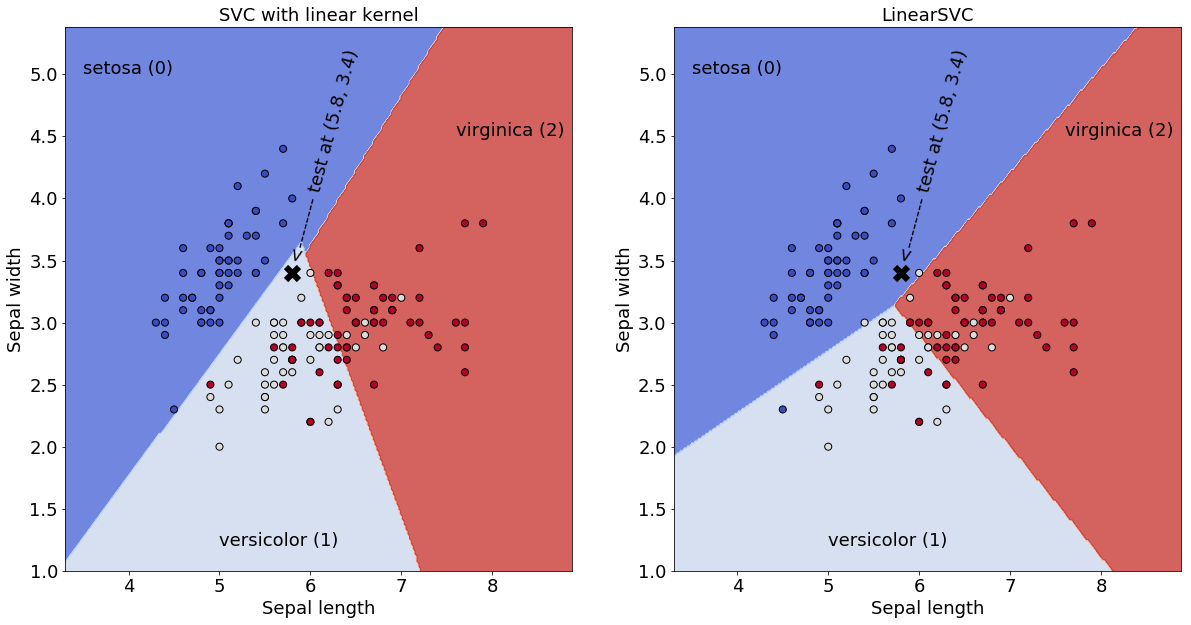

In [16]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (
    svm.SVC(kernel='linear', C=C),
    svm.LinearSVC(C=C, max_iter=10000),
)

# train the models and give them distinct names so they can be used
# after the plotting is done
svc = models[0].fit(X, y)
lin_svc = models[1].fit(X,y)

models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = (
    'SVC with linear kernel',
    'LinearSVC',
)

fig, sub = plt.subplots(1, 2, figsize=(20,10))

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=50, edgecolors='k')
    ax.scatter(test_X0, test_X1, s=300, marker='X', color='k', linewidths=0.0)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length', fontsize=18)
    ax.set_ylabel('Sepal width', fontsize=18)
    ax.set_title(title, fontsize=18)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)
    
    # label the classes by name, determined from a little manual poking around
    # with iris.DESCR, iris.data, iris.target, and iris.target_names
    ax.text(3.5, 5, 'setosa (0)', fontsize=18)
    ax.text(5, 1.2, 'versicolor (1)', fontsize=18)
    ax.text(7.6, 4.5, 'virginica (2)', fontsize=18)
    ax.text(5.75, 5.1, '<-------- test at ({}, {})'.format(str(test_X0), str(test_X1)), fontsize=18, rotation=75)


plt.show()

Before plugging in the test point, plug in the three known points just to double-check:

Predicting the known points using the first classifier `svc` (which is an `sklearn.svm.SVC(kernel='linear')` model):

In [17]:
svc.predict(known_setosa), svc.predict(known_versicolor), svc.predict(known_virginica)

(array([0]), array([1]), array([2]))

Predicting the known points using the second classifier `lin_svc` (which is an `sklearn.svm.LinearSVC()` model):

In [18]:
lin_svc.predict(known_setosa), lin_svc.predict(known_versicolor), lin_svc.predict(known_virginica)

(array([0]), array([1]), array([2]))

Fine, that's exactly as it should be. Now compare the predictions for the test point, which is the point (`test_X0`, `test_X1`) plotted above as a black "X":

In [19]:
test_pt

array([[5.8, 3.4]])

The `sklearn.svm.SVC` model predicts the test point is a **versicolor (1)**:

In [20]:
svc.predict(test_pt)

array([1])

In contrast, the `sklearn.svm.LinearSVC` model predicts the test point is a **setosa (0)**:

In [21]:
lin_svc.predict(test_pt)

array([0])

Save the models to disk

In [22]:
joblib.dump(svc, 'svc/trained_classifier.pkl')
joblib.dump(lin_svc, 'lin_svc/trained_classifier.pkl')

!ls -lhtr */*.pkl

-rw-r--r--  1 dinesh.shenoy  COMMUNITY\Domain Users   5.5K Mar 20 18:12 svc/trained_classifier.pkl
-rw-r--r--  1 dinesh.shenoy  COMMUNITY\Domain Users   930B Mar 20 18:12 lin_svc/trained_classifier.pkl
